# Social Network Ad based Predictions

## Setting up the environment

In [34]:
import os
os.getcwd()

'C:\\Users\\MODY2\\OneDrive\\Desktop\\Selected Project\\Social-Network Ads using ann\\Social-Network-Ads-main'

In [35]:
pip install keras-tuner --upgrade

Requirement already up-to-date: keras-tuner in c:\users\mody2\anaconda3\lib\site-packages (1.1.0)
Note: you may need to restart the kernel to use updated packages.


In [36]:
import pandas as pd
df = pd.read_csv('Social_Network_Ads.csv')
# check for number of null entries
print('Data is packed' if not df.isnull().values.any() else 'Data contains missing values')
df.head()

Data is packed


,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [37]:
df.shape

(400, 5)

## Visualizing the data

### Heatmap

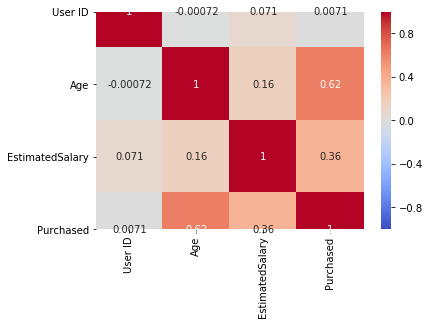

In [38]:
import seaborn as sb
import matplotlib.pyplot as plt

sb.heatmap(df.corr(), annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.show()

### Interpretable graph

<Figure size 432x288 with 0 Axes>

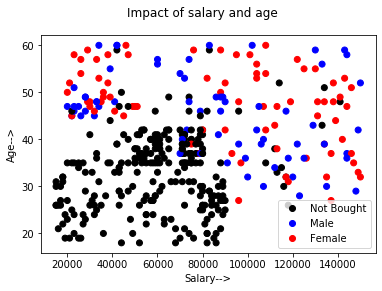

In [39]:
from matplotlib.colors import ListedColormap

# Age vs salary. Men are blue points, Females are Red points and No Buyers are black points
salaries = df['EstimatedSalary']
ages = df['Age']
genders = df['Gender']
buy_stats = df['Purchased']
colors = [1 if genders[i] == 'Male' and buy_stats[i] == 1 else 2 if genders[i] == 'Female' and buy_stats[i] == 1 else 0 for i in range(len(df['User ID'].tolist()))]
cmap = ListedColormap(['black','blue','red'])
classes = ['Not Bought', 'Male', 'Female']
plt.clf()

fig = plt.figure()
fig.suptitle("Impact of salary and age")
scatter = plt.scatter(salaries, ages, c = colors, cmap = cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.xlabel('Salary-->')
plt.ylabel('Age-->')
plt.show()

## Preprocessing the data

### Data Cleaning and Scaling

In [40]:
# User ID is irrelevant
df = df.drop(['User ID'], axis = 1)

# We can change Male and Female to 0 or 1
df['Gender'] = df['Gender'].apply(lambda gender: 0 if gender == 'Male' else 1)

# Normalize Age and EstimatedSalary based on mean and range
# value = (val - mean)/(max - min)

# Salary Normalization
import math
salaries = df['EstimatedSalary']
mean_salary = min(salaries) + max(salaries) / len(salaries)
salary_range = max(salaries) - min(salaries)
norm_salaries = [(salary - mean_salary) / salary_range for salary in salaries]

# Age normalization
ages = df['Age']
mean_age = min(ages) + max(ages) / len(ages)
age_range = max(ages) - min(ages)
norm_ages = [(age - mean_age) / age_range for age in ages]

# Assign to df
df['Age'] = norm_ages
df['EstimatedSalary'] = norm_salaries
df.head()

,Gender,Age,EstimatedSalary,Purchased
0,0,0.020238,0.026852,0
1,0,0.401190,0.034259,0
2,1,0.186905,0.204630,0
3,1,0.210714,0.308333,0
4,0,0.020238,0.449074,0


### Train and Test split

In [41]:
# Use 60% data as training data and 20% as validation data and 20% as test data
y = df.pop('Purchased').to_numpy()
X = df.to_numpy()

# Split
from sklearn.model_selection import train_test_split

# Train+Validation and Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
# Train and Validation split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25)

In [42]:
print(f'''Training size: {len(X_train)}
Validation size: {len(X_valid)}
Test size: {len(X_test)}''')

Training size: 240
Validation size: 80
Test size: 80


# Creating Keras Model

In [43]:
from tensorflow import keras

#ANN
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(X_train.shape[1], )))
model.add(keras.layers.Dense(int(X_train.shape[1]*2), input_dim=X_train.shape[1], activation='relu'))
model.add(keras.layers.Dense(X_train.shape[1]*2, activation = 'relu'))
model.add(keras.layers.Dense(X_train.shape[1]*2, activation = 'relu'))
model.add(keras.layers.Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 3)                 0         
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 24        
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_16 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 7         
Total params: 115
Trainable params: 115
Non-trainable params: 0
_________________________________________________________________
None


In [44]:
#Set epochs
epochs = 100

#Clear output
import IPython
class ClearTrainingOutput(keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output()
    
#Fit the model
trained_model = model.fit(X_train, y_train, epochs = epochs, validation_data = (X_valid, y_valid), callbacks = [ClearTrainingOutput()])

Max Acc Reached: 85.42 %


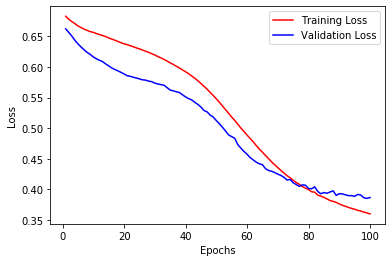

In [45]:
print('Max Acc Reached: {0:0.2f} %'.format((max(trained_model.history['acc']) * 100)) )
# Print the learning curve
plt.plot(range(1, epochs+1), trained_model.history['loss'] , 'r', range(1, epochs+1), trained_model.history['val_loss'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])

# Making Predictions

In [46]:
predictions = model.predict(X_test)
from sklearn.metrics import accuracy_score
predictions = [0 if prob < 0.5 else 1 for prob in predictions]
print("Test Set Accuracy: {0:0.2f} %".format(accuracy_score(y_test, predictions) * 100))

Test Set Accuracy: 86.25 %


# Creating auto-tuned Keras model

## Defining model with variable hyperparameters

In [47]:
from tensorflow import keras
import keras_tuner as kt
def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(X_train.shape[1], )))
    for i in range(hp.Int('layers', 1, 10)):
        model.add(keras.layers.Dense(
            units=hp.Int('units_' + str(i), X_train.shape[1], X_train.shape[1]*5, step = X_train.shape[1]),
            activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
        
    model.compile(optimizer = 'adam',
                loss = 'binary_crossentropy', 
                metrics = ['accuracy'])
    return model

tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 20,
                     factor = X_train.shape[1],
                     directory = 'auto_tuned_model',
                     project_name = 'soc_net_ad_pred')

tuner.search(X_train, y_train, epochs = 20, validation_data = (X_valid, y_valid), callbacks = [ClearTrainingOutput()])
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

INFO:tensorflow:Reloading Oracle from existing project auto_tuned_model\soc_net_ad_pred\oracle.json
INFO:tensorflow:Reloading Tuner from auto_tuned_model\soc_net_ad_pred\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [48]:
## Create model from tuned hypermodel
model = tuner.hypermodel.build(best_hps)
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 3)                 0         
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 12        
_________________________________________________________________
dense_21 (Dense)             (None, 12)                48        
_________________________________________________________________
dense_22 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_23 (Dense)             (None, 6)                 78        
_________________________________________________________________
dense_24 (Dense)             (None, 12)                84        
_________________________________________________________________
dense_25 (Dense)             (None, 15)               

## Train the model with best hyper parameters

In [49]:
epochs = 100
trained_model = model.fit(X_train, y_train, epochs = epochs, validation_data = (X_valid, y_valid), callbacks = [ClearTrainingOutput()])

Max Acc Reached: 94.17 %


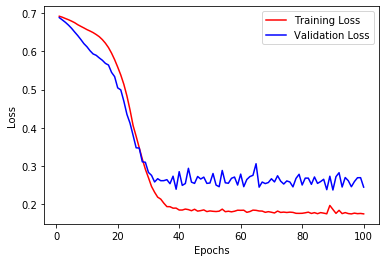

In [50]:
print('Max Acc Reached: {0:0.2f} %'.format((max(trained_model.history['acc']) * 100)) )
# Print the learning curve
plt.plot(range(1, epochs+1), trained_model.history['loss'] , 'r', range(1, epochs+1), trained_model.history['val_loss'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])

## Making predictions with auto-tuned model

In [51]:
predictions = model.predict(X_test)
from sklearn.metrics import accuracy_score
predictions = [0 if prob < 0.5 else 1 for prob in predictions]
print("Test Set Accuracy: {0:0.2f} %".format(accuracy_score(y_test, predictions) * 100))

Test Set Accuracy: 87.50 %
